# Kernel PCA Raw Signals

This notebook will look at the alternative kernels within the ```sklearn.decomposition.KernelPCA``` module. In this case all but ```linear``` which is implemented in the main ```sklearn.decomposition.PCA``` doesn't prove useful. Some of the principal components of the kernel methods generate outsized returns with one principal component, but for a *model improvement* all principal components must outperform. For the analysis of this notebook it will examine raw value and log value inputted values. The to compare returns first begin by comparing the sharpes of each security across each pca method, then the sharpes of equal weight and equal volatility contribution. 

While it may be worth investigating whether or not the fitted values from the kernel PCA work as good regressors, since their failure to generate returns on their own is weak, its not worth pursuing. 

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from   sklearn.decomposition import KernelPCA
from   tqdm import tqdm

import statsmodels.api as sm

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from PCSpreadOLS import PCASpreadOLS

In [3]:
tqdm.pandas()

## Prep Input Data

In [4]:
def prep_data() -> pd.DataFrame: 

    df_raw = pd.concat([
        (PCASpreadOLS().get_breakeven().drop(
            columns = ["Description"]).
            assign(
                curve    = "breakeven",
                security = lambda x: x.security.str.split(" ").str[0])),
        (PCASpreadOLS().get_inflation_swap().drop(
            columns = ["Description"]).
            assign(
                curve    = "inflation",
                security = lambda x: x.security.str.split(" ").str[0]))])
    
    df_out = (pd.concat([
        df_raw.assign(preprocess = "none"),
        df_raw.assign(value = lambda x: np.log(x.value + 100), preprocess = "log")]))

    return df_out

df_data = prep_data()

## Generate Each Signal

In this case generate kernel PCA of every kernel method, and then generate every signal

In [5]:
def _kernel_pca(df: pd.DataFrame, kernel: str) -> pd.DataFrame:
    
    df_wider = (df[
        ["date", "security", "value"]].
        pivot(index = "date", columns = "security", values = "value").
        dropna())

    df_out = (pd.DataFrame(
        data    = KernelPCA(n_components = 3, kernel = kernel).fit_transform(df_wider),
        index   = df_wider.index,
        columns = ["PC{}".format(i + 1) for i in range(3)]))

    return df_out
    

def _kernel_pcas(df: pd.DataFrame, kernels: list) -> pd.DataFrame: 

    df_out = pd.concat([
        _kernel_pca(df, kernel).assign(kernel = kernel) 
        for kernel in kernels])

    return df_out

def kernel_pcas(df_data: pd.DataFrame) -> pd.DataFrame: 
    
    kernels = ["linear", "poly", "rbf", "sigmoid", "cosine"]
    
    df_out = (df_data.assign(
        group_var = lambda x: x.curve + "_" + x.preprocess).
        groupby("group_var").
        progress_apply(lambda group: _kernel_pcas(group, kernels)).
        reset_index())

    return df_out

df_pca = kernel_pcas(df_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.94s/it]


In [6]:
def _lag_signal(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.sort_values(
        "date").
        assign(lag_spread = lambda x: x.spread.shift()).
        dropna())

    return df_out

def get_signal(df_pca: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_pca.melt(
        id_vars = ["date", "kernel", "group_var"]).
        assign(
            curve      = lambda x: x.group_var.str.split("_").str[0],
            preprocess = lambda x: x.group_var.str.split("_").str[1]).
        drop(columns = ["group_var"]).
        pivot(index = ["date", "preprocess", "variable", "kernel"], columns = "curve", values = "value").
        dropna().
        assign(spread = lambda x: x.inflation - x.breakeven).
        reset_index().
        assign(group_var = lambda x: x.preprocess + "_" + x.variable + "_" + x.kernel).
        groupby("group_var").
        apply(_lag_signal).
        reset_index(drop = True))

    return df_out

df_signal = get_signal(df_pca)

In [7]:
def get_signal_rtn(df_signal: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_signal.merge(
        right = PCASpreadOLS().get_tsy_fut(), how = "inner", on = ["date"])
        [["date", "preprocess", "variable", "kernel", "lag_spread", "security", "PX_bps"]].
        assign(
            security   = lambda x: x.security.str.split(" ").str[0],
            signal_bps = lambda x: np.sign(x.lag_spread) * x.PX_bps))

    return df_out

df_signal_rtn = get_signal_rtn(df_signal)

## Security Sharpe

In [8]:
def get_security_sharpe(df_signal_rtn: pd.DataFrame) -> pd.DataFrame: 

    df_tmp = (df_signal_rtn[
        ["preprocess", "variable", "kernel", "security", "signal_bps"]].
        groupby(["preprocess", "variable", "kernel", "security"]).
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        drop(columns = ["mean_rtn", "std_rtn"]).
        rename(columns = {"kernel": ""}).
        pivot(index = ["preprocess", "variable", "security"], columns = "", values = "sharpe").
        fillna(0).
        reset_index().
        assign(group_var = lambda x: x.preprocess + "_" + x.variable))

    return df_tmp

df_security_sharpe = get_security_sharpe(df_signal_rtn)

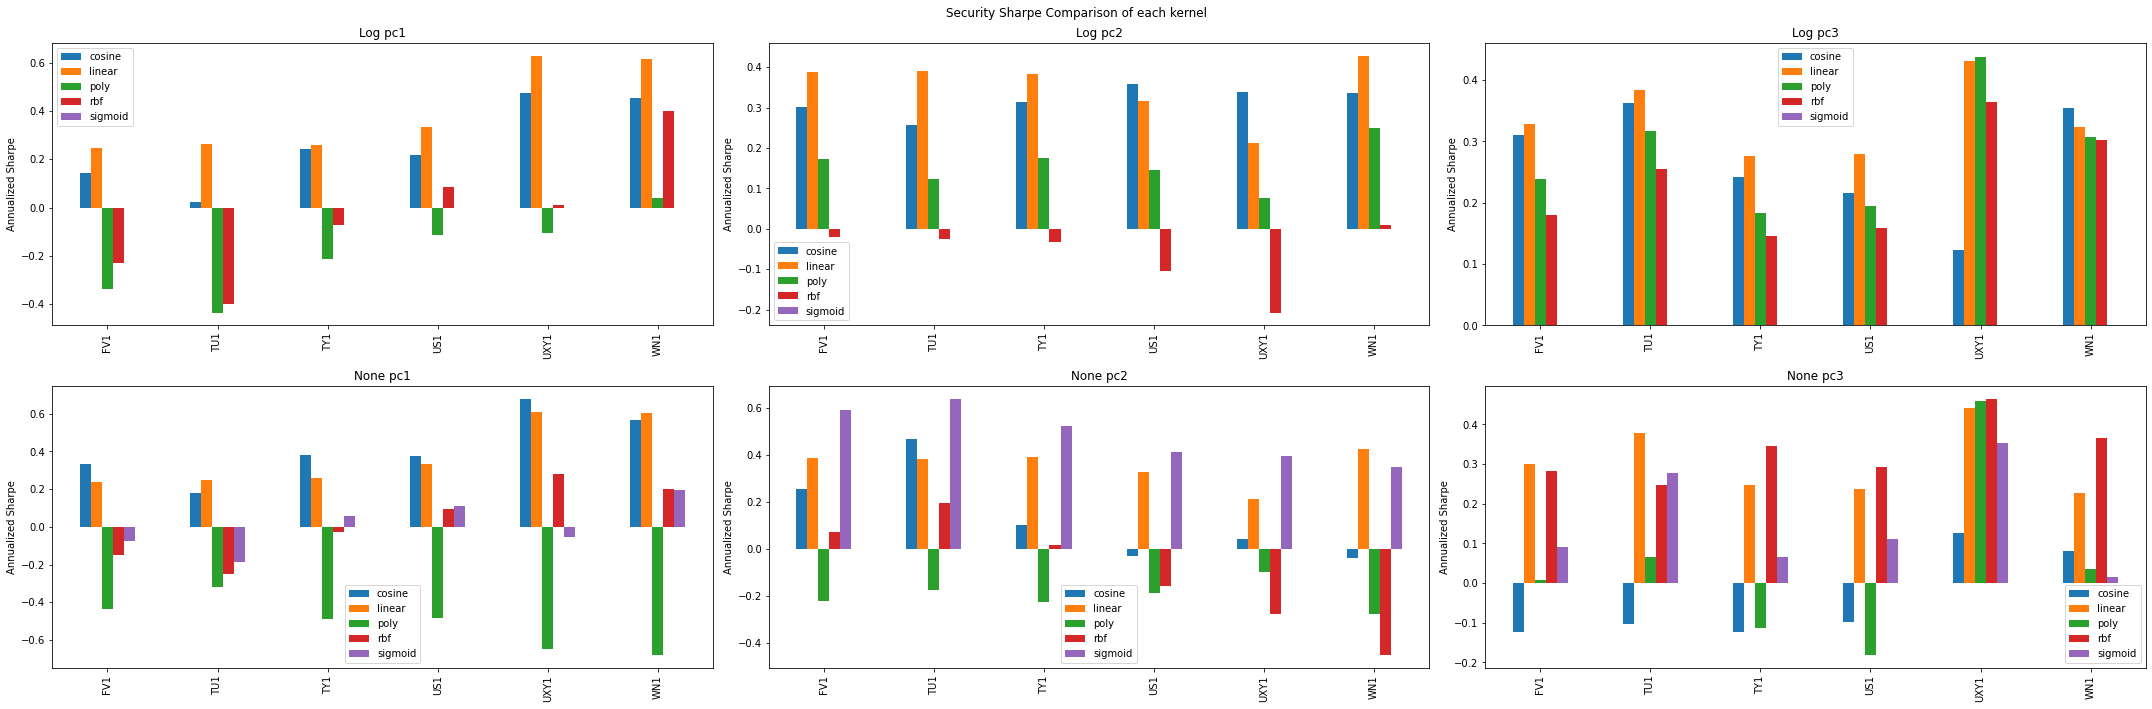

In [9]:
def plot_security_sharpe_comparison(df_security_sharpe: pd.DataFrame) -> plt.Figure: 

    variables = df_security_sharpe.group_var.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 3, figsize = (30,10))
    
    for variable, ax in zip(variables, axes.flatten()): 
    
        (df_security_sharpe.query(
            "group_var == @variable").
            set_index("security")
            [["cosine", "linear", "poly", "rbf", "sigmoid"]].
            plot(
                kind   = "bar",
                ax     = ax,
                xlabel = "",
                ylabel = "Annualized Sharpe",
                title  = variable.replace("_", " ").replace("pc", "PC").capitalize()))

    fig.suptitle("Security Sharpe Comparison of each kernel")
    plt.tight_layout()

plot_security_sharpe_comparison(df_security_sharpe)

## Average Weighted Return Sharpe

In [10]:
def get_avg_port_sharpe(df_signal_rtn: pd.DataFrame) -> pd.DataFrame: 

    df_sharpe = (df_signal_rtn.drop(
        columns = ["lag_spread", "PX_bps", "security"]).
        groupby(["date", "preprocess", "variable", "kernel"]).
        agg("mean").
        reset_index().
        drop(columns = ["date"]).
        groupby(["preprocess", "variable", "kernel"]).
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        fillna(0)
        [["sharpe"]].
        reset_index())

    return df_sharpe

df_avg_sharpe = get_avg_port_sharpe(df_signal_rtn)

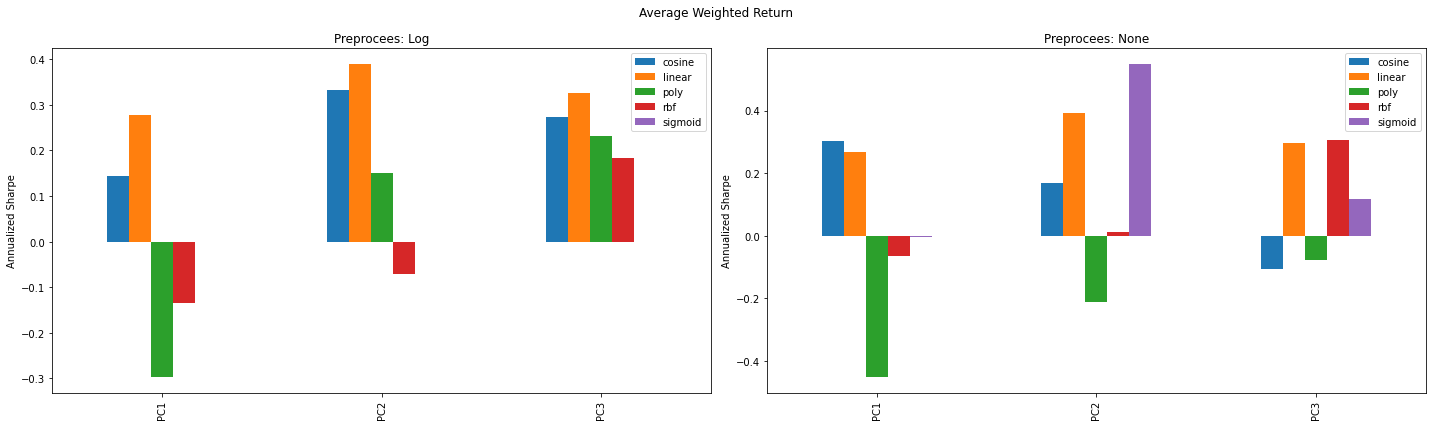

In [11]:
def plot_avg_sharpe_comaprison(df_avg_sharpe: pd.DataFrame) -> plt.Figure: 

    variables = df_avg_sharpe.preprocess.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_avg_sharpe.query(
            "preprocess == @variable").
            drop(columns = ["preprocess"]).
            rename(columns = {"kernel": ""}).
            pivot(index = "variable", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                ylabel = "Annualized Sharpe",
                title  = "Preprocees: " + variable.replace("_", " ").capitalize()))

    fig.suptitle("Average Weighted Return")
    plt.tight_layout()

plot_avg_sharpe_comaprison(df_avg_sharpe)

## Equal Risk Contribution Portfolio

In [12]:
def _get_erc(df: pd.DataFrame, window: int) -> pd.DataFrame: 

    df_out = (df.drop(
        columns = ["preprocess", "variable", "kernel"]).
        pivot(index = "date", columns = "security", values = "signal_bps").
        ewm(span = window, adjust = False).
        std().
        shift().
        apply(lambda x: 1 / x).
        reset_index().
        melt(id_vars = "date").
        dropna().
        rename(columns = {"value": "inv_vol"}))

    df_out = (df_out.drop(
        columns = ["security"]).
        groupby("date").
        agg("sum").
        rename(columns = {"inv_vol": "cum_vol"}).
        merge(right = df_out, how = "inner", on = ["date"]).
        merge(right = df, how = "inner", on = ["date", "security"]).
        assign(weight_rtn = lambda x: x.inv_vol / x.cum_vol * x.signal_bps)
        [["date", "weight_rtn"]].
        groupby("date").
        agg("sum"))

    return df_out

def get_erc_sharpe(df_signal_rtn: pd.DataFrame, window: int = 30) -> pd.DataFrame: 
    
    df_out = (df_signal_rtn.drop(
        columns = ["lag_spread", "PX_bps"]).
        assign(group_var = lambda x: x.preprocess + " " + x.variable + " " + x.kernel).
        groupby("group_var").
        apply(_get_erc, window).
        reset_index().
        drop(columns = ["date"]).
        groupby(["group_var"]).
        agg(["mean", "std"])
        ["weight_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        fillna(0).
        assign(
            preprocess = lambda x: x.group_var.str.split(" ").str[0],
            pc         = lambda x: x.group_var.str.split(" ").str[1],
            kernel     = lambda x: x.group_var.str.split(" ").str[2]).
        drop(columns = ["group_var"]))
    
    return df_out

df_erc = get_erc_sharpe(df_signal_rtn)

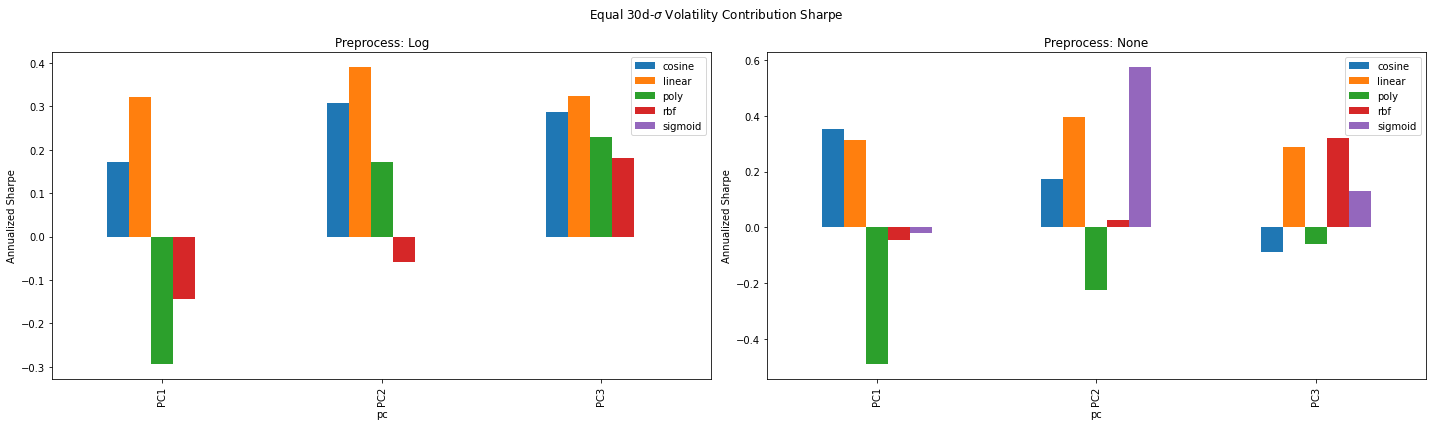

In [13]:
def plot_erc_sharpe(df_erc: pd.DataFrame) -> plt.Figure: 

    variables = df_erc.preprocess.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_erc.query(
            "preprocess == @variable")
            [["sharpe", "pc", "kernel"]].
            rename(columns = {"kernel": ""}).
            pivot(index = "pc", columns = "", values = "sharpe").
            plot(
                kind   = "bar",
                ax     = ax,
                ylabel = "Annualized Sharpe",
                title  = "Preprocess: " + variable.capitalize()))
    
    fig.suptitle("Equal 30d-{} Volatility Contribution Sharpe".format(r"$\sigma$"))
    plt.tight_layout()

plot_erc_sharpe(df_erc)